# Tutorial 3: Sine Wave Problem
This tutorial uses a toy problem to demonstrate how MHD learns multiple outputs. This problem is from Bishop's paper on Mixture Density Networks (MDNs).

In [1]:
import torch

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from models.mlp import MLP
from models.mixtureFFN import MixtureFFN
from models.mixtureOM import MixtureOfMultiFunction

sns.set_style('ticks')
sns.set_palette("Set1")

# %matplotlib notebook
DEVICE = 'cpu'


#### Helper Functions

In [2]:
def train_loop(X_data, Y_data, model, optimizer, epochs=10, display=100, batch_size=32, device='cuda:0', **kwargs):
    model.train()
    optimizer.zero_grad()
    total_steps = int(np.ceil(len(X_data) / batch_size))
    count = 0
    
    indexes = torch.randperm(Y_data.shape[0])
    X_shuffled = X_data[indexes]
    Y_shuffled = Y_data[indexes]

    model = model.to(device)

    ema_loss = {}

    for epoch in range(epochs):
        for step in range(total_steps):
            count += 1
            x = X_shuffled[step * batch_size:step * batch_size + batch_size]
            y = Y_shuffled[step * batch_size:step * batch_size + batch_size]
            
            log_loss = train_step(x, y, model, optimizer, device=device)

            for l_name, l_value in log_loss.items():
                if l_name not in ema_loss:
                    ema_loss[l_name] = l_value
                else:
                    ema_loss[l_name] = l_value * 0.2 + ema_loss[l_name] * 0.8

            if count % display == 0:
                print_str = f"E{epoch + 1}: "
                for l_name, l_value in ema_loss.items():
                    print_str += "{}: {:.5f} ".format(l_name, l_value)
                print(print_str)

            if hasattr(model, "restart_unused_mixtures"):
                model.restart_unused_mixtures()
            
            if hasattr(model, "set_epoch"):
                model.set_epoch(epoch)

def train_step(x, y, model, optimizer, device='cuda:0'):
    x = x.to(device)
    y = y.to(device)
    optimizer.zero_grad()
    log_loss = {}

    if model.__class__.__name__ == 'MLP':
        loss = model(x,y)[-1]
        log_loss['loss'] = loss.mean().detach().item()
    else:
        outputs, log_loss = model.loss(x, y=y)
        loss = outputs['loss'].mean() 
        log_loss['loss'] = loss.detach().item()

    loss.backward()
    optimizer.step()
    return log_loss



### 1. Create Two Clusters

In [3]:
dataset_sz = 1000

eps = np.random.uniform(-0.1, 0.1, size=dataset_sz)

# Define the x values (input)
Y_numpy = np.linspace(0, 1, num=dataset_sz)  # Adjust the num parameter to control the number of points

# Generate the y values (output) using the sine wave equation
X_numpy = Y_numpy + 0.3 * np.sin(2 * np.pi * Y_numpy) + eps

XY_concat = np.concatenate(( X_numpy.reshape(-1, 1), Y_numpy.reshape(-1, 1)), axis=1)

#Convert to torch
X = torch.from_numpy(X_numpy).view(-1,1).float()
Y = torch.from_numpy(Y_numpy).view(-1,1).float()

print(X.shape, Y.shape)

torch.Size([1000, 1]) torch.Size([1000, 1])


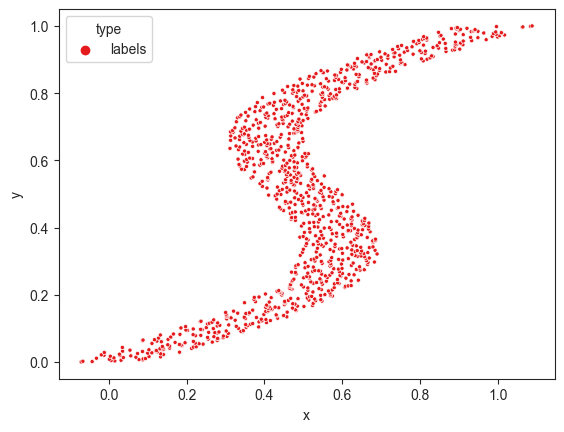

In [4]:
### Visualize reversed sinwave function. Multiple outputs given same input
df = pd.DataFrame(XY_concat, columns=['x', 'y'])
df['type'] = 'labels'
df['size'] = 1.0
sns.scatterplot(data=df, x='x', y='y', hue='type', marker='.')

plt.show()

Notice that there are multiple values of x for every y.

### 2. Initialize Hierarchical MH Dropout

In [5]:
# Model parameters
dropout_rate     = 0.5
inp_dim          = 1
out_dim          = 1
hid_dim          = 6
mhd_hid_dim      = 6

mix_components   = 3         
num_layers       = 6

var_weight       = 1.0
subset_ratio     = 0.2

gate_sampling    = 'exact'
distance_loss    = 'mse'
act_fn           = 'tanh'
out_act_fn       = 'tanh'

random_restart   = True       # (True, False)            Restarts unused mixtures  
sampling_policy  = 'multi'   # (greedy, multi, random)  Sampling policy for mixtures during inference

models = {}

In [6]:
models['FFN'] = MLP(
    inp_dim=inp_dim, 
    hid_dim=hid_dim, 
    out_dim=out_dim,
    num_layers=20, 
    act_fn=act_fn, 
    out_act_fn=out_act_fn, 
    distance_loss=distance_loss,
    dropout=0.0
)


models['MixtureFFN_MC_Dropout'] = MixtureFFN(
    mix_components=mix_components, 
    inp_dim=inp_dim, 
    hid_dim=hid_dim, 
    out_dim=out_dim, 
    num_layers=num_layers,
    act_fn=act_fn,
    out_act_fn=out_act_fn,
    dropout=0.5,
    random_restart=random_restart,
    sampling_policy=sampling_policy
)


In [7]:
models['MoM_MH_Dropout'] = MixtureOfMultiFunction(
    mix_components=mix_components,
            inp_dim=inp_dim, 
            hid_dim=hid_dim, 
            out_dim=out_dim, 
            mhd_hid_dim=mhd_hid_dim,
            num_layers=num_layers,
            act_fn=act_fn,
            out_act_fn=out_act_fn,
            gate_sampling=gate_sampling,
            subset_ratio=subset_ratio,
            distance_loss=distance_loss,
            var_weight=var_weight
            )


In [8]:
model_names = ['FFN','MixtureFFN_MC_Dropout','MoM_MH_Dropout']

# Check parameter counts. 
for model_name, model in models.items():
    param_count = sum(p.numel() for p in model.parameters())
    print("{:50} param={}".format(model_name, param_count))

FFN                  param=775
MixtureFFN_MC_Dropout param=762
MoM_MH_Dropout       param=1140


In [9]:
opts = {}
for model_name, model in models.items():
    opts[model_name] = torch.optim.Adam(list(models[model_name].parameters()), lr=0.0005)


### 3. Visualize hypotheses and labels (Y) before training.

In [10]:
def sample_model(model, X_data, max_hypos, df, sizes, samples=50):
    model.eval()
    model.cpu()
    X_data.cpu()
    x = X_data

    if model.__class__.__name__ == 'MixtureOfMultiFunction':
        with torch.no_grad():
            outputs = model.sample(x=X_data)

        mu = outputs['mu']
        sigma = outputs['sigma']
        samples = outputs['samples']
        #Prepare inputs for graph
        temp_df = np.concatenate([x, samples], axis=-1)
        temp_df = pd.DataFrame(temp_df, columns=['x', 'y'])
        temp_df['type'] = 'samples' 
        temp_df['size'] = sizes[1]
        df = pd.concat([df, temp_df], axis=0)
        #Prepare inputs for graph
        temp_df = np.concatenate([x, mu], axis=-1)
        temp_df = pd.DataFrame(temp_df, columns=['x', 'y'])
        temp_df['type'] = 'mu' 
        temp_df['size'] = sizes[0]
        df = pd.concat([df, temp_df], axis=0)

        temp_df = np.concatenate([x, sigma.cpu().numpy()], axis=-1)
        temp_df = pd.DataFrame(temp_df, columns=['x', 'y'])
        temp_df['type'] = 'sigma'
        temp_df['size'] = sizes[-1]
        df = pd.concat([df, temp_df], axis=0)

    elif model.__class__.__name__ in ['MixtureFFN']:

        # Predictive Mean: Turn dropout off.
        model.eval()
        with torch.no_grad():
            output = model.sample(x=x)
            mu = output['pred_sample'] 
            pidx = output['pidx_sample']

        #Predictive variance: Turn dropout on.
        model.train()
        with torch.no_grad():
            hypos = torch.stack([torch.stack([f(x) for f in model.ensemble], dim=-2) for _ in range(samples)], dim=-2)
            all_sigma = hypos[torch.arange(mu.size(0)), pidx]
            sigma = torch.std(all_sigma, dim=1)
            samples = torch.randn_like(x) * sigma + mu

        temp_df = np.concatenate([x, samples.cpu().numpy()], axis=-1)
        temp_df = pd.DataFrame(temp_df, columns=['x', 'y'])
        temp_df['type'] = 'samples'
        temp_df['size'] = sizes[-1]
        df = pd.concat([df, temp_df], axis=0)

        mu_df = np.concatenate([x, mu.cpu().numpy()], axis=-1)
        temp_df = pd.DataFrame(mu_df, columns=['x', 'y'])
        temp_df['type'] = 'mu'
        temp_df['size'] = sizes[0]
        df = pd.concat([df, temp_df], axis=0)

        temp_df = np.concatenate([x, sigma.cpu().numpy()], axis=-1)
        temp_df = pd.DataFrame(temp_df, columns=['x', 'y'])
        temp_df['type'] = 'sigma'
        temp_df['size'] = sizes[-1]
        df = pd.concat([df, temp_df], axis=0)

    elif model.__class__.__name__ in ['MLP']:
        
        x = X_data

        # Predictive Mean: Turn dropout off.
        model.eval()
        with torch.no_grad():
            mu = model.sample(x=x, hypo_count=max_hypos)['pred_sample'] 

        #Predictive variance: Turn dropout on.
        model.train()
        with torch.no_grad():
            preds = [model.sample(x=x, hypo_count=max_hypos)['pred_sample'] for _ in range(samples)]
            preds = torch.stack(preds, dim=1)
            sigma = torch.std(preds, dim=1)
            samples = torch.randn_like(x) * sigma + mu

        temp_df = np.concatenate([x, samples.cpu().numpy()], axis=-1)
        temp_df = pd.DataFrame(temp_df, columns=['x', 'y'])
        temp_df['type'] = 'samples'
        temp_df['size'] = sizes[-1]
        df = pd.concat([df, temp_df], axis=0)

        mu_df = np.concatenate([x, mu.cpu().numpy()], axis=-1)
        temp_df = pd.DataFrame(mu_df, columns=['x', 'y'])
        temp_df['type'] = 'mu'
        temp_df['size'] = sizes[0]
        df = pd.concat([df, temp_df], axis=0)

    else:
        print(model.__class__.__name__)
        raise

    return df

### 4. Train model

Train the model until loss is stable.


In [11]:
epochs = 15000
display = 5000
batch_size = 1000

In [12]:
for model_name, model in models.items():
    train_loop(X, Y, model, opts[model_name], epochs=epochs, display=display, batch_size=batch_size, device=DEVICE)

E5000: loss: 0.05809 
E10000: loss: 0.03865 
E15000: loss: 0.03775 
E5000: loss_dist: 0.00318 loss_coeff: 0.84035 loss: 0.21327 
E10000: loss_dist: 0.00293 loss_coeff: 0.83606 loss: 0.21195 
E15000: loss_dist: 0.00297 loss_coeff: 0.83288 loss: 0.21119 
E5000: loss_dist1: 0.00202 loss_dist2: 0.00009 loss_coeff: 0.85699 loss: 0.21636 
E10000: loss_dist1: 0.00180 loss_dist2: 0.00007 loss_coeff: 0.88866 loss: 0.22403 
E15000: loss_dist1: 0.00176 loss_dist2: 0.00006 loss_coeff: 0.87935 loss: 0.22166 


### 5. Visualize hypotheses and labels (Y) *after* training.

In [14]:
steady_dfs = {}
max_hypos = None
sizes = [1.1,1.0]
for model_name, model in models.items():
        steady_dfs[model_name] = sample_model(model, X, max_hypos, df, sizes)

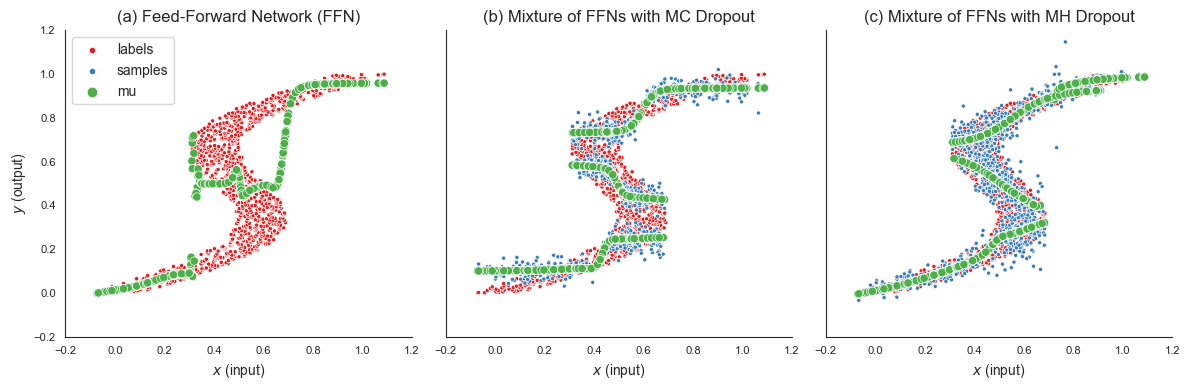

In [15]:
xlim = (-0.2, 1.2)
ylim = (-0.2, 1.2)

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True, sharex=True) 

# Steady State:
for idx, model_name in enumerate(model_names):
    data = steady_dfs[model_name]
    data = data[data['type'] != 'sigma']

    sns.scatterplot(data=data, x='x', y='y', hue='type', style='type', markers=['.','.','o'], ax=axes[idx], legend=True)
    axes[idx].set_xlim(*xlim)
    axes[idx].set_ylim(*ylim)
    axes[idx].set_xlabel('$x$ (input)')
    axes[idx].set_ylabel('$y$ (output)')

    axes[idx].spines['top'].set_visible(False)
    axes[idx].spines['right'].set_visible(False)
    axes[idx].tick_params(axis='x', labelsize=8)
    axes[idx].tick_params(axis='y', labelsize=8)
    axes[idx].tick_params(left=False, bottom=False)  

axes[0].set_title('(a) Feed-Forward Network (FFN)')
axes[1].set_title('(b) Mixture of FFNs with MC Dropout')
axes[2].set_title('(c) Mixture of FFNs with MH Dropout')

axes[0].legend(title=None, frameon=True) 

for idx in range(1,3):
    axes[idx].legend().remove() 

plt.tight_layout()